# Data Analysis

Let's better understand what we're dealing with. What does the data look like?

---

In [13]:
# Set up the env.
#!conda init
#!conda env list ## to see the availble options
#!conda activate civil_unrest ## to activate the targeted env


In [14]:
# Imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import folium
from matplotlib import colors
from geopy.distance import geodesic

#%pip install folium pandas matplotlib geopy

--- 

Let's load the data

---

In [15]:
# Load the data from the CSV file
data = pd.read_csv('data.csv')

# Display the first few rows of the dataframe
data.head()

,SQLDATE,EventCode,ActionGeo_FullName,ActionGeo_Lat,ActionGeo_Long,AvgTone
0,20240823,145,"Union Park, Illinois, United States",41.8839,-87.6648,-3.046968
1,20240822,145,"Union Park, Illinois, United States",41.8839,-87.6648,0.000000
2,20240820,145,"Union Park, Illinois, United States",41.8839,-87.6648,-4.319654
3,20240820,145,"Union Park, Illinois, United States",41.8839,-87.6648,-4.319654
4,20240627,145,"Buckingham Fountain, Illinois, United States",41.8756,-87.6189,-7.052186


---

## Event Date & Time

Let's take a look at when the events occured.


---

In [16]:
# Create a copy of the data DataFrame
data_copy = data.copy()

# Convert SQLDATE to datetime format
data_copy['SQLDATE'] = pd.to_datetime(data_copy['SQLDATE'], format='%Y%m%d')

# Aggregate the data by date to avoid duplicate labels and sum the AvgTone
data_aggregated = data_copy.groupby('SQLDATE').agg({'EventCode': 'size', 'AvgTone': 'sum'}).reset_index()

# Rename the columns
data_aggregated.columns = ['SQLDATE', 'Number of Events', 'Total AvgTone']

# Set the date column as the index
data_aggregated.set_index('SQLDATE', inplace=True)

# Create a date range from the minimum to the maximum date in the DataFrame
all_dates = pd.date_range(start=data_aggregated.index.min(), end=data_aggregated.index.max())

# Reindex the DataFrame to include all dates in the range, filling missing values with 0
reindex_data = data_aggregated.reindex(all_dates, fill_value=0).reset_index()

# Rename the columns
reindex_data.columns = ['SQLDATE', 'Number of Events', 'Total AvgTone']

# Display the resulting DataFrame
reindex_data


,SQLDATE,Number of Events,Total AvgTone
0,2015-12-25,1,-12.850954
1,2015-12-26,0,0.000000
2,2015-12-27,0,0.000000
3,2015-12-28,0,0.000000
4,2015-12-29,0,0.000000
...,...,...,...
3160,2024-08-19,0,0.000000
3161,2024-08-20,2,-8.639309
3162,2024-08-21,0,0.000000
3163,2024-08-22,1,0.000000


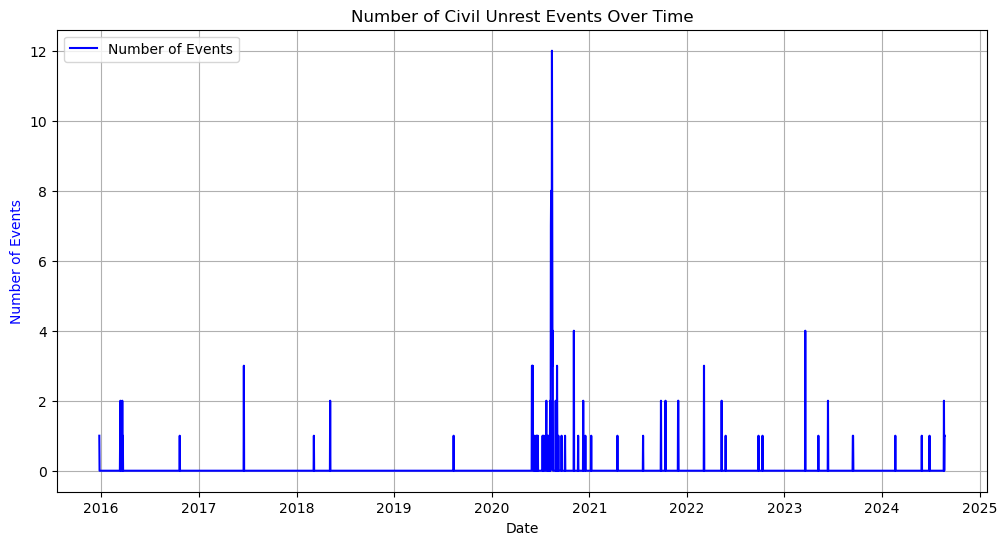

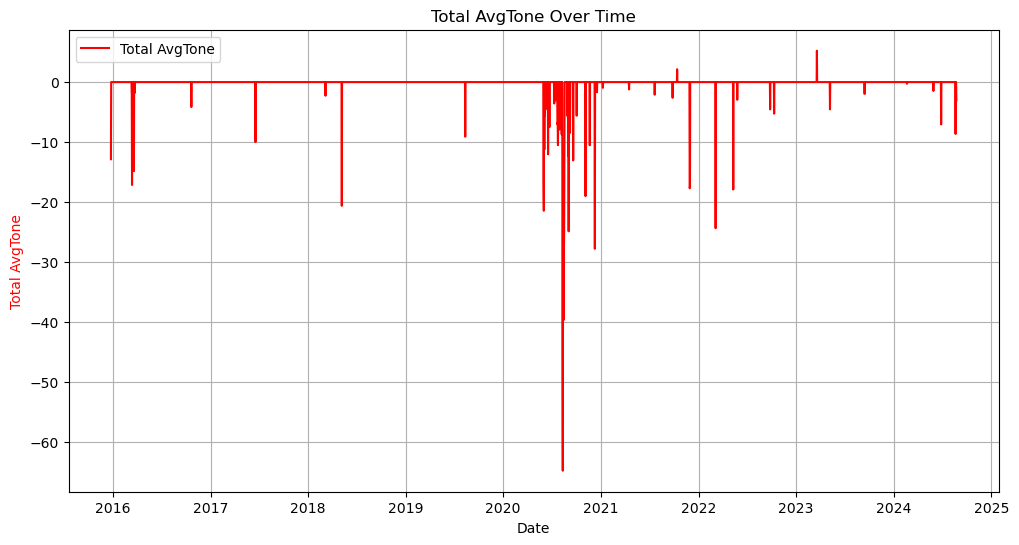

In [17]:
# Plot the number of events
plt.figure(figsize=(12, 6))
plt.plot(reindex_data['SQLDATE'], reindex_data['Number of Events'], label='Number of Events', color='b')
plt.xlabel('Date')
plt.ylabel('Number of Events', color='b')
plt.title('Number of Civil Unrest Events Over Time')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# Plot the Total AvgTone
plt.figure(figsize=(12, 6))
plt.plot(reindex_data['SQLDATE'], reindex_data['Total AvgTone'], label='Total AvgTone', color='r')
plt.xlabel('Date')
plt.ylabel('Total AvgTone', color='r')
plt.title('Total AvgTone Over Time')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


---

The South Loop neighborhood in Chicago experienced significant protest activity during the summer of 2020, particularly in late May and early June, following the death of George Floyd. On May 30, 2020, protests escalated into unrest and looting, resulting in substantial damage to businesses in the South Loop. Reports indicate that on May 31, 2020, the area was left with major damage as it prepared for another night of protests.

---

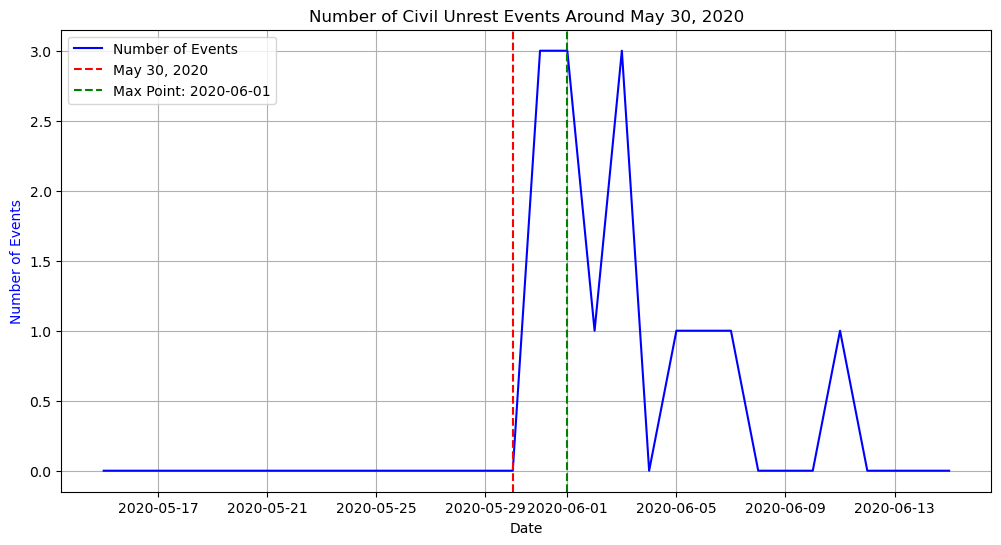

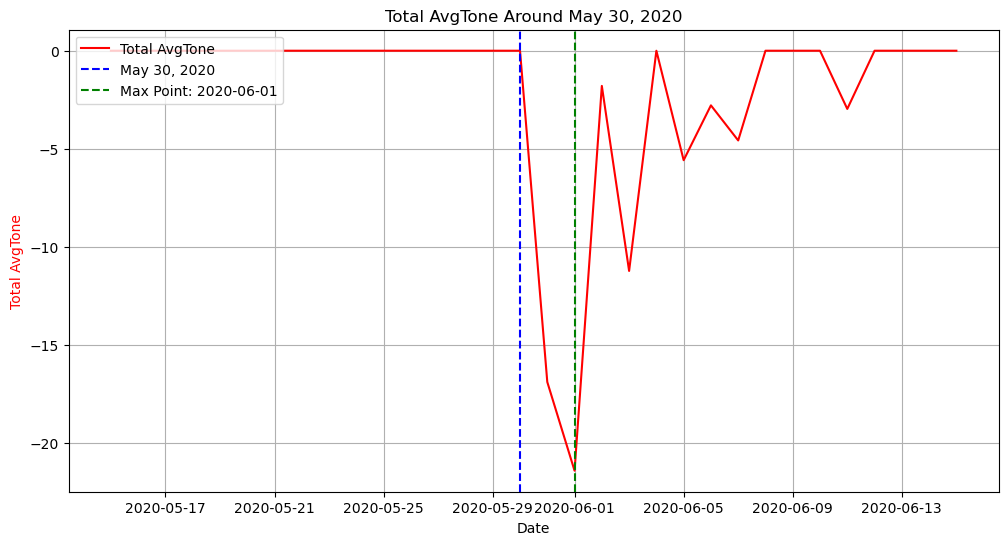

Max Point Date: 2020-06-01 00:00:00
Number of Events: 3
Total AvgTone: -21.43985497343055


In [18]:
# Filter the dataframe for the specified date range
filtered_df = reindex_data[(reindex_data['SQLDATE'] >= pd.Timestamp('2020-05-15')) & (reindex_data['SQLDATE'] <= pd.Timestamp('2020-06-15'))]

# Find the date with the highest Total AvgTone in the filtered range
max_point = filtered_df.loc[filtered_df['Total AvgTone'].idxmin()]

# Plot the number of events over time
plt.figure(figsize=(12, 6))
plt.plot(filtered_df['SQLDATE'], filtered_df['Number of Events'], label='Number of Events', color='b')
plt.axvline(x=pd.Timestamp('2020-05-30'), color='r', linestyle='--', label='May 30, 2020')
plt.axvline(x=max_point['SQLDATE'], color='g', linestyle='--', label=f'Max Point: {max_point["SQLDATE"].date()}')
plt.xlabel('Date')
plt.ylabel('Number of Events', color='b')
plt.title('Number of Civil Unrest Events Around May 30, 2020')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# Plot the Total AvgTone over time
plt.figure(figsize=(12, 6))
plt.plot(filtered_df['SQLDATE'], filtered_df['Total AvgTone'], label='Total AvgTone', color='r')
plt.axvline(x=pd.Timestamp('2020-05-30'), color='b', linestyle='--', label='May 30, 2020')
plt.axvline(x=max_point['SQLDATE'], color='g', linestyle='--', label=f'Max Point: {max_point["SQLDATE"].date()}')
plt.xlabel('Date')
plt.ylabel('Total AvgTone', color='r')
plt.title('Total AvgTone Around May 30, 2020')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

print(f"Max Point Date: {max_point['SQLDATE']}")
print(f"Number of Events: {max_point['Number of Events']}")
print(f"Total AvgTone: {max_point['Total AvgTone']}")

---

It's clear that Total AvgTone looks like an excellent data label for determining how "disruptive" an event was. 

Let's take a closer look at the peaks in the data

---

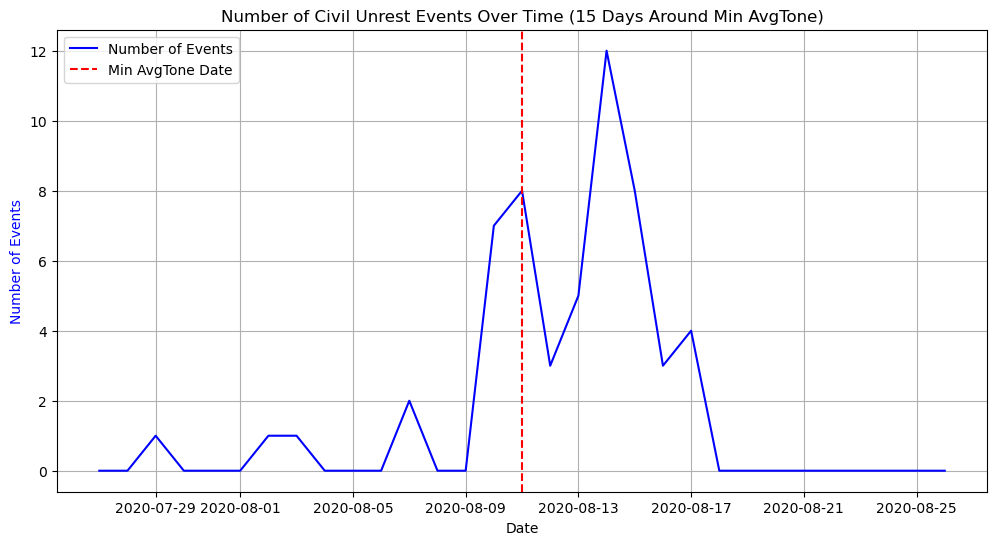

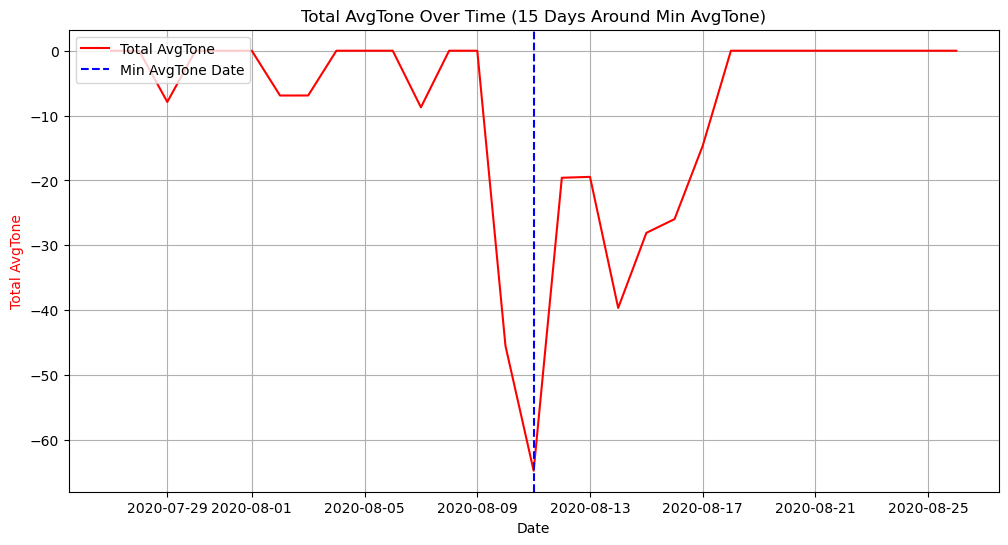

Min AvgTone Date: 2020-08-11 00:00:00
Total AvgTone: -64.75445402343503


In [19]:
# Find the date with the minimum Total AvgTone
min_avg_tone_date = reindex_data.loc[reindex_data['Total AvgTone'].idxmin()]

# Extract the date and Total AvgTone
min_avg_tone_date_value = min_avg_tone_date['SQLDATE']
min_avg_tone_value = min_avg_tone_date['Total AvgTone']

# Define the date range for 15 days before and after the minimum Total AvgTone date
start_date = min_avg_tone_date_value - pd.Timedelta(days=15)
end_date = min_avg_tone_date_value + pd.Timedelta(days=15)

# Filter the dataframe for the specified date range
filtered_df = reindex_data[(reindex_data['SQLDATE'] >= start_date) & (reindex_data['SQLDATE'] <= end_date)]

# Plot the number of events over time and highlight the minimum Total AvgTone date
plt.figure(figsize=(12, 6))
plt.plot(filtered_df['SQLDATE'], filtered_df['Number of Events'], label='Number of Events', color='b')
plt.axvline(x=min_avg_tone_date_value, color='r', linestyle='--', label='Min AvgTone Date')
plt.xlabel('Date')
plt.ylabel('Number of Events', color='b')
plt.title('Number of Civil Unrest Events Over Time (15 Days Around Min AvgTone)')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# Plot the Total AvgTone over time and highlight the minimum Total AvgTone date
plt.figure(figsize=(12, 6))
plt.plot(filtered_df['SQLDATE'], filtered_df['Total AvgTone'], label='Total AvgTone', color='r')
plt.axvline(x=min_avg_tone_date_value, color='b', linestyle='--', label='Min AvgTone Date')
plt.xlabel('Date')
plt.ylabel('Total AvgTone', color='r')
plt.title('Total AvgTone Over Time (15 Days Around Min AvgTone)')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

print(f"Min AvgTone Date: {min_avg_tone_date_value}")
print(f"Total AvgTone: {min_avg_tone_value}")

---

## Saving Test & Train Data

I like the reindex_data better than the original formulation. Let's quickly save test and train sets. I want to capture a really bad protest, and then see if it can predict some of the events in 2023.

Splitting on 2021 seems like a solid choice to capture both types of events.

---

In [12]:
# Split the data into before and after 2021
train_data = reindex_data[reindex_data['SQLDATE'] < '2021-01-01']
test_data = reindex_data[reindex_data['SQLDATE'] >= '2021-01-01']

# Display the resulting dataframes
print("Train Data:")
display(train_data.head())
print("\nTest Data:")
display(test_data.head())

Train Data:


,SQLDATE,Number of Events,Total AvgTone
0,2015-12-25,1,-12.850954
1,2015-12-26,0,0.000000
2,2015-12-27,0,0.000000
3,2015-12-28,0,0.000000
4,2015-12-29,0,0.000000



Test Data:


,SQLDATE,Number of Events,Total AvgTone
1834,2021-01-01,0,0.0
1835,2021-01-02,0,0.0
1836,2021-01-03,0,0.0
1837,2021-01-04,0,0.0
1838,2021-01-05,0,0.0


In [24]:
# Save the train and test data to CSV files
train_data.to_csv('train_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)

---

## Event Duplication

---

One other thing I want to check - is there any duplicate events at the same location?

---

In [20]:
# Check for duplicate events based on all columns
duplicate_events = data[data.duplicated()]

# Display the duplicate events based on all columns
print("Duplicate events based on all columns:")
display(duplicate_events)

Duplicate events based on all columns:


,SQLDATE,EventCode,ActionGeo_FullName,ActionGeo_Lat,ActionGeo_Long,AvgTone
3,20240820,145,"Union Park, Illinois, United States",41.8839,-87.6648,-4.319654
10,20230613,145,"World Trade Center, Illinois, United States",41.8889,-87.6303,0.000000
13,20230320,145,"Art Institute Of Chicago, Illinois, United States",41.8795,-87.6223,1.306141
14,20230320,145,"Art Institute Of Chicago, Illinois, United States",41.8795,-87.6223,1.306141
15,20230320,145,"Art Institute Of Chicago, Illinois, United States",41.8795,-87.6223,1.306141
20,20220511,145,"Chicago River, Illinois, United States",41.8867,-87.6373,-8.947368
22,20220306,145,"Chicago Loop, Illinois, United States",41.8811,-87.6298,-8.115543
23,20220306,145,"Chicago Loop, Illinois, United States",41.8811,-87.6298,-8.115543
25,20211130,145,"Wicker Park, Illinois, United States",41.9075,-87.6770,-8.672087
27,20211129,145,"Wicker Park, Illinois, United States",41.9075,-87.6770,-8.847185


---

This is rather odd. I'll revert to investigate more later.

---

---

## Event Total AvgTone Distribution

---

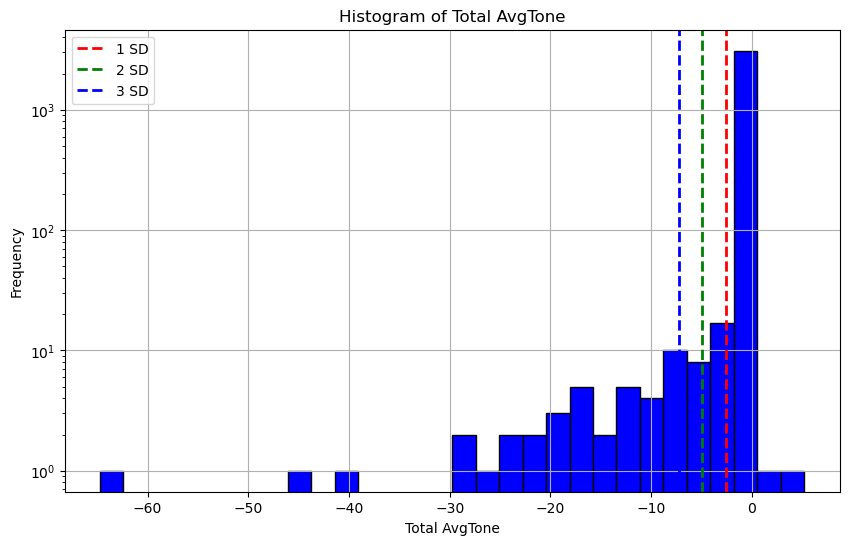

In [21]:
# Calculate mean and standard deviation
mean_avg_tone = reindex_data['Total AvgTone'].mean()
std_avg_tone = reindex_data['Total AvgTone'].std()

# Create a histogram of Total AvgTone with linear scale
plt.figure(figsize=(10, 6))
plt.hist(reindex_data['Total AvgTone'], bins=30, color='blue', edgecolor='black')
plt.xlabel('Total AvgTone')
plt.ylabel('Frequency')
plt.title('Histogram of Total AvgTone')
plt.yscale('log')
plt.grid(True)

# Add vertical lines for 1 SD, 2 SD, and 3 SD
plt.axvline(mean_avg_tone - std_avg_tone, color='r', linestyle='dashed', linewidth=2, label='1 SD')
plt.axvline(mean_avg_tone - 2 * std_avg_tone, color='g', linestyle='dashed', linewidth=2, label='2 SD')
plt.axvline(mean_avg_tone - 3 * std_avg_tone, color='b', linestyle='dashed', linewidth=2, label='3 SD')

# Add legend
plt.legend()
plt.show()


---

I included a logorithmic distribution becuase clearly most days in Chicago have very few events (thank God!). I also included the SD of events in the graph, to see how rare some of the events were. However, this is not normally distributed, so it's not really the most relevant of an input.

---


---

While this distribution is not normal, it's clear that anything above 3 SD is a bad day, as the spread is high. 

For context, the George Floyd riots had a tone of -21.43985497343055.

Let's create and then measure the CDF at 3 SD.

---




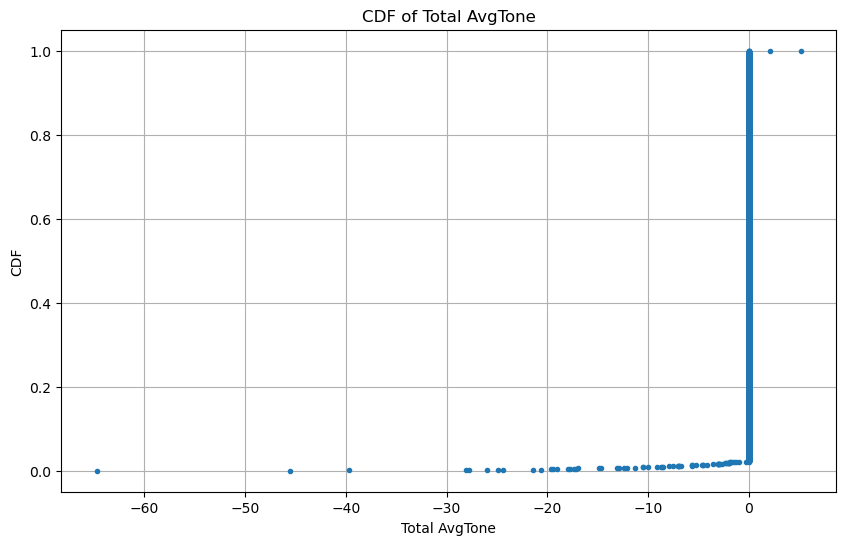

In [22]:
def cdf(data):
    """Compute the CDF of a given dataset."""
    data_sorted = np.sort(data)
    cdf_values = np.arange(1, len(data_sorted) + 1) / len(data_sorted)
    return data_sorted, cdf_values

# Compute the CDF for Total AvgTone
total_avg_tone_sorted, total_avg_tone_cdf = cdf(reindex_data['Total AvgTone'])

# Plot the CDF
plt.figure(figsize=(10, 6))
plt.plot(total_avg_tone_sorted, total_avg_tone_cdf, marker='.', linestyle='none')
plt.xlabel('Total AvgTone')
plt.ylabel('CDF')
plt.title('CDF of Total AvgTone')
plt.grid(True)
plt.show()

In [23]:
# Calculate the value for mean_avg_tone - 3 * std_avg_tone
SD_3 = mean_avg_tone - 3 * std_avg_tone

# Find the index where the sorted Total AvgTone is just greater than or equal to the threshold value
index = np.searchsorted(total_avg_tone_sorted, SD_3, side='right')

# Get the corresponding CDF value
cdf_value = total_avg_tone_cdf[index - 1] if index > 0 else 0.0

print(f"CDF of 3 Standard Deviations {SD_3}: {cdf_value*100}%, meaning events that are at least as bad occur {cdf_value*100}% of the time")

print(f"In other words, these are events are as {cdf_value*100}% rare")

CDF of 3 Standard Deviations -7.223690377534689: 1.074249605055292%, meaning events that are at least as bad occur 1.074249605055292% of the time
In other words, these are events are as 1.074249605055292% rare


---

# Conclusion

Ok. Now we have a handle on WHEN out events occur, and how rare they (.e.g, how bad they are)

Now let's begin to build a model to predict this information.

---
